In [18]:
import numpy as np
from matplotlib import pyplot as plt
from dynamics import run_sim
from model import Model

In [19]:
#Global parameters
n_loci = 9
n_gens = 15
t = (0, 1000)
p1 = 0.2
p2 = 0.2
sigma1 = 0.2
sigma2 = 0.2
beta = 0.005
res_type = 'add'

In [20]:
def normalize(model, b_min=0.2):
	model.F = model.F - np.min(model.F) + b_min*np.max(model.F)
	model.F = model.F / np.max(model.F)

	model.B = model.B - np.min(model.B)
	model.B = model.B / np.max(model.B)

In [21]:
from itertools import combinations

def add_epistasis(model, order, p, sigma):
    pairs = np.array(list(combinations(range(model.n_loci), order)))
    sample = pairs[np.where(np.random.binomial(1, p, len(pairs)) == 1)]

    r_effects = np.random.normal(1, sigma, len(sample))
    
    for i, ind in enumerate(sample):
        ind = list(ind)
        for gtp_ind, gtp in enumerate(model.G):
            if np.all(gtp[ind] == 1):
                if model.r_type == 'add':
                    model.B[gtp_ind] += np.sum(model.r_i[ind])
                    model.B[gtp_ind] -= r_effects[i]*(np.sum(model.r_i[ind]))
                elif model.r_type == 'mult':
                    model.B[gtp_ind] /= np.prod(np.subtract(1, model.r_i[ind]))
                    model.B[gtp_ind] *= (r_effects[i]*np.prod(np.subtract(1, model.r_i[ind])))

In [139]:
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

sim = Model(n_loci, res, cost, beta=beta, r_type=res_type)
normalize(sim)
sim.B = sim.B * sim.beta

X_t, I_t = run_sim(sim, t, n_gens)

n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, sim.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < sim.B,sim.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

t_ticks = np.linspace(0, 1, 7)*n_time_bins
t_tick_labels = np.linspace(0, n_gens, 7, dtype=np.uint)

r_ticks = np.linspace(0, 1, 5)*n_res_bins
r_tick_labels = np.linspace(1, 0, 5)

In [47]:
def diversity_panel(n_sims, n_loci=n_loci, epistasis=0, n_gens=n_gens, t=t, beta=beta):
	shannon_div = np.zeros(n_sims)

	sim = Model(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta, r_type=res_type)
	n_mono = 0
	n_poly = 0

	for i in range(n_sims):
		cost = np.random.exponential(0.1, n_loci)
		res = np.random.exponential(0.1, n_loci)

		sim.update_loci(res, cost)
		if epistasis == 1:
			add_epistasis(sim, 2, p1, sigma1)
		elif epistasis == 2:
			add_epistasis(sim, 2, p1, sigma1)
			add_epistasis(sim, 3, p2, sigma2)

		normalize(sim)
		sim.B = sim.B * sim.beta

		X_t, _ = run_sim(sim, t, n_gens)

		if np.sum(X_t[:, -1] > 5) > 1:
			n_poly += 1
		else:
			n_mono += 1

		eq_prop = X_t[:,-1] / np.sum(X_t[:,-1])
		shannon_div[i] = len(eq_prop[eq_prop > 0.1])
		eq_prop = eq_prop[eq_prop > 0]
		shannon_div[i] = -np.sum(eq_prop*np.log(eq_prop))


	return shannon_div, n_poly/(n_poly+n_mono)

In [141]:
no_epi, prop1 = diversity_panel(100, epistasis=0, n_loci=9)
epi_1, prop2 = diversity_panel(100, epistasis=1, n_loci=9)
epi_2, prop3 = diversity_panel(100, epistasis=2, n_loci=9)

In [146]:
prop2

0.37

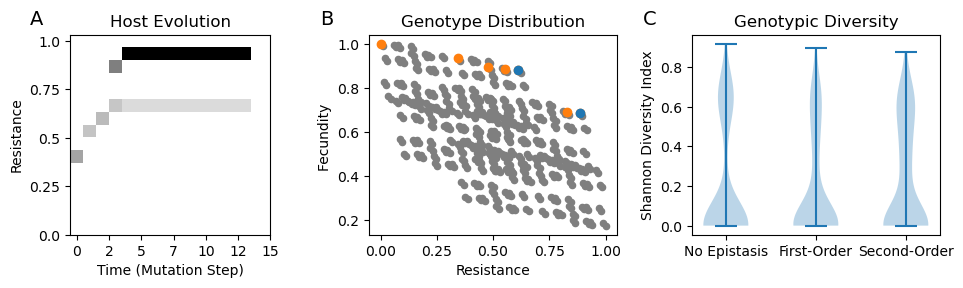

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

genotypes = ax[0].imshow(np.log(1+evol_plot), cmap='Greys')
ax[0].set_title('Host Evolution')
ax[0].set_ylabel('Resistance')
ax[0].set_xlabel('Time (Mutation Step)')
ax[0].set_xticks(t_ticks)
ax[0].set_yticks(r_ticks)
ax[0].set_xticklabels(t_tick_labels)
ax[0].set_yticklabels(r_tick_labels)

abundances = np.max(X_t, axis=1)
ax[1].set_title('Genotype Distribution')
ax[1].set_xlabel('Resistance')
ax[1].set_ylabel('Fecundity ')
ax[1].scatter((1-(sim.B/sim.beta))[abundances<=1], sim.F[abundances<=1], c='tab:gray', s=20)
ax[1].scatter((1-(sim.B/sim.beta))[abundances>1], sim.F[abundances>1], c='tab:orange')
ax[1].scatter((1-(sim.B/sim.beta))[X_t[:,-1]>1], sim.F[X_t[:,-1]>1], c='tab:blue')

ax[2].set_title('Genotypic Diversity')
ax[2].violinplot((no_epi, epi_1, epi_2))
ax[2].set_xticks([1,2,3], ['No Epistasis', 'First-Order', 'Second-Order'])
ax[2].set_ylabel('Shannon Diversity Index')

ax[0].annotate("A", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.05), xycoords="axes fraction", fontsize=14)

plt.tight_layout()


In [147]:
from scipy.stats import f_oneway

f_oneway(no_epi, epi_1, epi_2)

F_onewayResult(statistic=0.6215488656733916, pvalue=0.5378090362480377)

In [86]:
np.sum(X_t[:,-1] > 5)

2